In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np

# set seed
torch.manual_seed(54)
torch.cuda.manual_seed(54)

In [2]:
BATCH_SIZE = 64
NUM_WORKERS = 2

# extracting a small subset of the CIFAR10 dataset
# about subset: 1000 images for each of 4 classes namely: airplane, automobile, bird, cat
# 4000 images in total
# 80% train and 20% test
# why subset: gpu poor :(

classes = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3}
img_per_class = 1000

# transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
])


# load data
dataset = torchvision.datasets.CIFAR10(root='./data',
                                          train=True,
                                          download=True,
                                          transform=test_transform)

# class indices
class_indices = {k:[] for k in classes.values()}

for idx, (img, label) in enumerate(dataset):
    if label in class_indices and len(class_indices[label]) < img_per_class:
        class_indices[label].append(idx)

    if all(len(num_indices)== img_per_class for num_indices in class_indices.values()):
        break

# create subset
total_indices = sum(class_indices.values(),[])
subset_dataset = Subset(dataset, total_indices)

# train and test split
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_data, test_data = random_split(subset_dataset, [train_size, test_size])

# apply transform to test set separately
train_data.dataset.transform = train_transform


train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)

print(f'Train data size: {len(train_data)} images, Test data size: {len(test_data)} images')


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


Train data size: 3200 images, Test data size: 800 images


In [3]:
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7da140650510>,
 <torch.utils.data.dataloader.DataLoader at 0x7da25154e790>)

In [4]:
# patch embedding

class PatchEmbedding(nn.Module):
    def __init__(self,
                img_size=224,
                patch_size = 16,
                in_channels = 3,
                embedding_dim = 768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size

        self.num_patches = (img_size//patch_size)**2

        # 1. images -> patches -> linear proj on each patch
        self.proj = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding=0)
        self.flatten = nn.Flatten(2,3)
        # 2. adding cls(class) token
        self.cls_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                                     requires_grad= True) # by default-> true
        # 3. positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches+1,embedding_dim),
                                         requires_grad= True)

    def forward(self, x):

        x = self.proj(x)
        x = x.flatten(2,3)
        x = x.transpose(1,2)
        # print(f'Patched image shape: {x.shape}')

        batch_size = x.shape[0]
        cls_token = self.cls_token.expand(batch_size, -1,-1)

        # prepend cls token
        x = torch.cat((cls_token, x), dim=1)
        # print(f'patch embedding with cls token shape: {x.shape}')

        # add pos
        x = x + self.pos_embedding
        # print(f'patch + cls + pos shape: {x.shape}')
        return x


In [5]:
# get an image from train dataloader for debugging

batch_img, batch_label = next(iter(train_loader))

# single img
img, label = batch_img[0], batch_label[0]
print(f'Input image shape: {img.shape}')


patchin = PatchEmbedding(img_size=224,
                        patch_size = 16,
                        in_channels = 3,
                        embedding_dim = 768)
# add batch dim
img = img.unsqueeze(0)
print(f'Input image shape after adding batch dim: {img.shape}')

output_from_patch_embedding = patchin(img)

Input image shape: torch.Size([3, 224, 224])
Input image shape after adding batch dim: torch.Size([1, 3, 224, 224])


tensor(0)


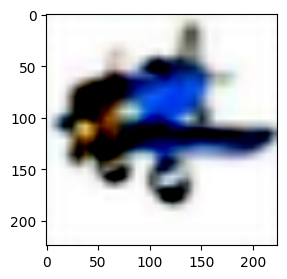

In [6]:
import matplotlib.pyplot as plt
# plot
img_ = img.squeeze(0)
img_ = img_.permute(1,2,0)

plt.figure(figsize = (6,3))
plt.imshow(img_);
print(label)

inspiration from [code](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html)

In [7]:
# multi head attention
import math

class MultiHeadAttention(nn.Module):
    def __init__(self,
                 embedding_dim = 768,
                 num_heads = 12,
                 dropout=0.1):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim =  embedding_dim // num_heads

        self.qkv_proj = nn.Linear(embedding_dim, embedding_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embedding_dim, embedding_dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):

        # batch_size, num_patches+1, embedding_dim = x.shape
        batch_size, num_patches, embedding_dim = x.shape
        # print(f'input to multi head attention: {x.shape}')

        qkv = self.qkv_proj(x).reshape(batch_size, num_patches, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0,2,1,3) # [batch_size, num_heads, num_patches, dim]
        q,k,v = qkv.chunk(3, dim=-1)

        # scaled dot-product
        attn = (torch.matmul(q, k.transpose(-2,-1)))/ math.sqrt(self.head_dim)

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = torch.matmul(attn, v)
        x = x.permute(0,2,1,3) # [batch_size, num_patches, num_heads, dim]
        x = x.reshape(batch_size, num_patches, embedding_dim)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


In [8]:
# a dummy forward pass
attentionin = MultiHeadAttention(embedding_dim = 768,
                                 num_heads = 12)

output_from_multi_head_attention = attentionin(output_from_patch_embedding)
print(f'output_from_multi_head_attention shape: {output_from_multi_head_attention.shape}')

output_from_multi_head_attention shape: torch.Size([1, 197, 768])


In [9]:
# MLP

class MLP(nn.Module):
    def __init__(self,
                 embedding_dim=768,
                 mlp_size=3072,
                 dropout=0.):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.mlp_size = mlp_size

        self.mlp = nn.Sequential(
            nn.Linear(in_features= embedding_dim,
                     out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = mlp_size,
                     out_features = embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

In [10]:
mlpin = MLP(embedding_dim=768,
            mlp_size=3072,
            dropout= 0.1)

output_through_mlp_layer = mlpin(output_from_multi_head_attention)
print(f'Output through mlp layer shape: {output_through_mlp_layer.shape}')

Output through mlp layer shape: torch.Size([1, 197, 768])


In [11]:
# TransformerBlock

class TransformerBlock(nn.Module):
    def __init__(self,
               embedding_dim = 768,
               num_heads = 12,
               mlp_size=3072,
               mlp_dropout = 0.1,
               attn_dropout = 0.1):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.attn_dropout = attn_dropout
        self.mlp_size = mlp_size
        self.mlp_dropout = mlp_dropout


        self.layer_norm1 = nn.LayerNorm(normalized_shape = embedding_dim)
        self.attn = MultiHeadAttention(embedding_dim=embedding_dim,
                                       num_heads=num_heads,
                                       dropout = attn_dropout
                                      )
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        self.mlp = MLP(embedding_dim=embedding_dim,
                       mlp_size=mlp_size,
                       dropout=mlp_dropout)


    def forward(self,x):
        # layer norm and attn with residual conn
        x = x + self.attn(self.layer_norm1(x))

        # layer norm and mlp with residual conn
        x = x + self.mlp(self.layer_norm2(x))
        return x

In [12]:
# ViT

class ViT(nn.Module):
    def __init__(self,
                 img_size = 224,
                 patch_size = 16,
                 in_channels = 3,
                 num_classes = 10,
                 embedding_dim = 768,
                 mlp_size = 3072,
                 num_heads = 12,
                 attn_dropout = 0.1,
                 mlp_dropout = 0.1,
                 num_transformer_layer = 12):
        super().__init__()

        self.num_classes = num_classes
        # patch embedding
        self.patch_embed = PatchEmbedding(
            img_size = img_size,
            patch_size = patch_size,
            in_channels = in_channels,
            embedding_dim = embedding_dim
        )

        # transformer encoder
        self.transformer_encoder = nn.Sequential(*[
            TransformerBlock(embedding_dim = embedding_dim,
                            num_heads = num_heads,
                            mlp_size = mlp_size,
                            mlp_dropout = mlp_dropout)
            for _ in range(num_transformer_layer)
        ])

        # classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
            x = self.patch_embed(x)
            x = self.transformer_encoder(x)
            x = self.classifier(x[:,0]) # only cls token
            return x

In [13]:
# pass img through the model

vit = ViT(img_size = 224,
          patch_size = 16,
          in_channels = 3,
          num_classes = 4,
          embedding_dim = 768,
          mlp_size = 3072,
          num_heads = 12,
          attn_dropout = 0.1,
          mlp_dropout = 0.1,
          num_transformer_layer = 12)
vit(img)

tensor([[0.1008, 0.2467, 1.6555, 0.2636]], grad_fn=<AddmmBackward0>)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Inspiration from [code](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py)

In [15]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from tqdm.auto import tqdm
import torch

def train_step(model, dataloader, loss_fn, optimizer,
              device):

    model.train()

    train_loss, train_acc = 0,0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # print(f"X shape: {X.shape}, y shape: {y.shape}")
        # print(f"y values: {y.unique()}")

        y_pred = model(X)

        # print(f"y_pred shape: {y_pred.shape}")

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += ((y_pred_class== y).sum().item())/len(y_pred)

    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc


def test_step(model, dataloader, loss_fn, device):

    model.eval()

    test_loss, test_acc = 0,0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_label = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
            test_acc += ((test_pred_label == y).sum().item())/len(test_pred_label)

    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    return test_loss, test_acc


def train(model,
         train_dataloader,
         test_dataloader,
         optimizer,
         loss_fn,
         epochs,
         device):
    results = {'train_loss': [],
              'train_acc': [],
              'test_loss':[],
              'test_acc':[]}


    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model= model,
                                          dataloader= train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer = optimizer,
                                          device = device)
        test_loss, test_acc = test_step(model=model,
                                       dataloader= test_dataloader,
                                       loss_fn = loss_fn,
                                       device = device)

        print(
            f'epoch: {epoch+1} | '
            f'train loss: {train_loss:.4f} | '
            f'train acc: {train_acc:.4f} | '
            f'test loss: {test_loss:.4f} | '
            f'test acc: {test_acc:.4f} | '
        )


        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = vit.parameters(),
                            lr=0.0003,
                            betas = (0.9,0.99),
                            weight_decay = 0.5)

In [17]:
results = train(model = vit,
               train_dataloader = train_loader,
               test_dataloader = test_loader,
               optimizer = optimizer,
               loss_fn = loss_fn,
               epochs= 10,
               device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 | train loss: 1.4907 | train acc: 0.3009 | test loss: 1.4263 | test acc: 0.3257 | 
epoch: 2 | train loss: 1.3933 | train acc: 0.2825 | test loss: 1.3827 | test acc: 0.2728 | 
epoch: 3 | train loss: 1.3930 | train acc: 0.2369 | test loss: 1.3922 | test acc: 0.2728 | 
epoch: 4 | train loss: 1.3941 | train acc: 0.2422 | test loss: 1.4071 | test acc: 0.2212 | 
epoch: 5 | train loss: 1.3957 | train acc: 0.2503 | test loss: 1.3904 | test acc: 0.2476 | 
epoch: 6 | train loss: 1.3951 | train acc: 0.2491 | test loss: 1.3979 | test acc: 0.2212 | 
epoch: 7 | train loss: 1.3922 | train acc: 0.2525 | test loss: 1.4146 | test acc: 0.2212 | 
epoch: 8 | train loss: 1.3958 | train acc: 0.2459 | test loss: 1.3991 | test acc: 0.2476 | 
epoch: 9 | train loss: 1.3904 | train acc: 0.2584 | test loss: 1.3866 | test acc: 0.2584 | 
epoch: 10 | train loss: 1.3941 | train acc: 0.2625 | test loss: 1.3945 | test acc: 0.2476 | 


In [18]:
# save model dict
torch.save(vit.state_dict(), "vit_cifar10.pth")
print("Model saved as vit_cifar10.pth")

Model saved as vit_cifar10.pth


In [19]:
import os

file_name = "vit_cifar10.pth"
file_size = os.path.getsize(file_name)

print(f"File Size in Bytes is: {file_size}")
print(f"File Size in MegaBytes is: {file_size / (1024 * 1024):.2f} MB")

File Size in Bytes is: 343267634
File Size in MegaBytes is: 327.37 MB


Plots saved to ./training_metrics.png


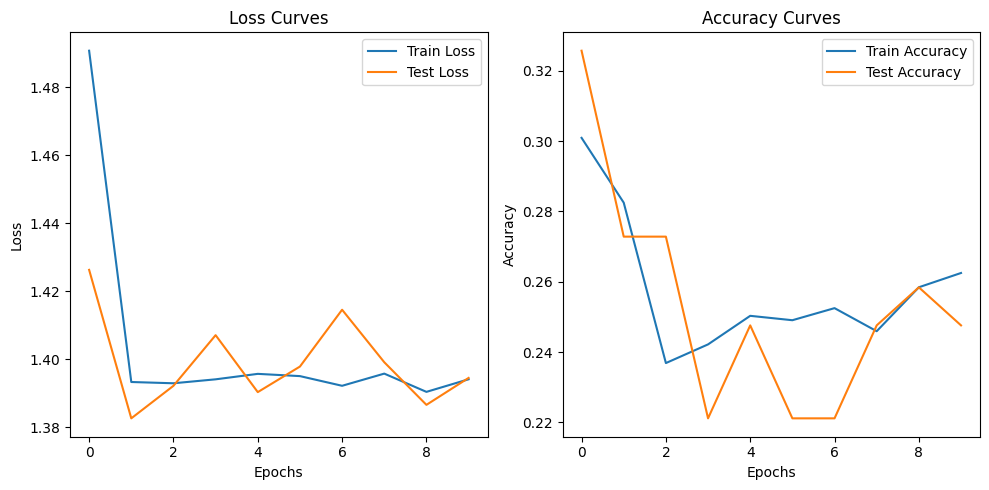

In [20]:
import matplotlib.pyplot as plt

def save_plots(results, save_dir='.'):
    """Save loss and accuracy plots"""
    # Create plots directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(results['train_loss'], label='Train Loss')
    plt.plot(results['test_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(results['train_acc'], label='Train Accuracy')
    plt.plot(results['test_acc'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_metrics.png'))
    print(f"Plots saved to {os.path.join(save_dir, 'training_metrics.png')}")

save_plots(results)